In [5]:
# Data Cleaning and EDA Script
import pandas as pd, numpy as np
from pathlib import Path

# 1. Load raw data
RAW = Path("../data/raw/Salary_Data.csv")
df = pd.read_csv(RAW)

# 2. Standardize column names
#    Age -> age
#    Gender -> gender
#    Education Level -> education_level
#    Job Title -> job_title
#    Years of Experience -> years_of_experience
#    Salary -> salary
df = df.rename(columns={
    "Age": "age",
    "Gender": "gender",
    "Education Level": "education_level",
    "Job Title": "job_title",
    "Years of Experience": "years_of_experience",
    "Salary": "salary",
})

# 3. Basic cleaning: remove duplicates + handle missing values
df = df.drop_duplicates()

num_cols = df.select_dtypes(include=[np.number]).columns
cat_cols = [c for c in df.columns if c not in num_cols]

# Numeric columns: fill missing values using median
for c in num_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].median())

# Categorical columns: fill missing values with "Unknown"
for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna("Unknown")

print("After cleaning missing values:", df.shape)
display(df.isna().sum().sort_values(ascending=False).head(10))

# 4. Normalize gender values
df["gender"] = df["gender"].astype(str).str.strip().str.lower()
gender_map = {
    "m": "male",
    "male": "male",
    "f": "female",
    "female": "female",
}
df["gender"] = df["gender"].replace(gender_map)

# 5. Normalize education_level (merge different spellings)
df["education_level"] = df["education_level"].astype(str).str.strip()

edu_map = {
    "Associate": "Associate",
    "associate": "Associate",
    "Bachelor": "Bachelor",
    "Bachelors": "Bachelor",
    "Bachelor's": "Bachelor",
    "Master": "Master",
    "Masters": "Master",
    "Master's": "Master",
    "PhD": "PhD",
    "Ph.D.": "PhD",
    "phd": "PhD",
}
df["education_level"] = df["education_level"].replace(edu_map)

df["job_title"] = df["job_title"].astype(str).str.strip()

df["job_title"] = df["job_title"].str.title()

job_title_map = {
    "Ml Engineer": "Machine Learning Engineer",
    "Machine Learning Eng": "Machine Learning Engineer",
    "Machine Learning Engineer Ii": "Machine Learning Engineer",
    "Sr Data Scientist": "Data Scientist",
    "Senior Data Scientist": "Data Scientist",
}
df["job_title"] = df["job_title"].replace(job_title_map)

# 7. Remove duplicates again (since merging may have created completely duplicate rows)
df = df.drop_duplicates()

print("\nAfter reducing redundant inputs:", df.shape)
print(df.columns)
df.info()


After cleaning missing values: (325, 6)


age                    0
gender                 0
education_level        0
job_title              0
years_of_experience    0
salary                 0
dtype: int64


After reducing redundant inputs: (325, 6)
Index(['age', 'gender', 'education_level', 'job_title', 'years_of_experience',
       'salary'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 325 entries, 0 to 371
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  325 non-null    float64
 1   gender               325 non-null    object 
 2   education_level      325 non-null    object 
 3   job_title            325 non-null    object 
 4   years_of_experience  325 non-null    float64
 5   salary               325 non-null    float64
dtypes: float64(3), object(3)
memory usage: 17.8+ KB


In [6]:
# outlier removal on salary
salary_col = "salary"

Q1, Q3 = df[salary_col].quantile([0.25, 0.75])
IQR = Q3 - Q1
lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR

before = df.shape[0]
df = df[(df[salary_col] >= lower) & (df[salary_col] <= upper)]
after = df.shape[0]
print(f"Removed outliers: {before - after} rows | New shape: {df.shape}")


Removed outliers: 0 rows | New shape: (325, 6)


In [ ]:
print(df.dtypes)
print("\nTop job titles:")
print(df["job_title"].value_counts().head(10))


age                    float64
gender                  object
education_level         object
job_title               object
years_of_experience    float64
salary                 float64
dtype: object

Top job titles:


KeyError: 'Job Title'

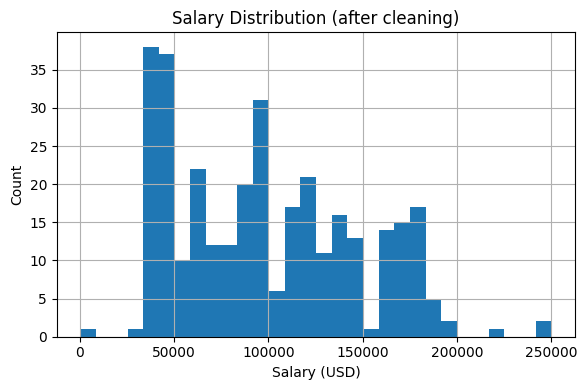

<Figure size 800x400 with 0 Axes>

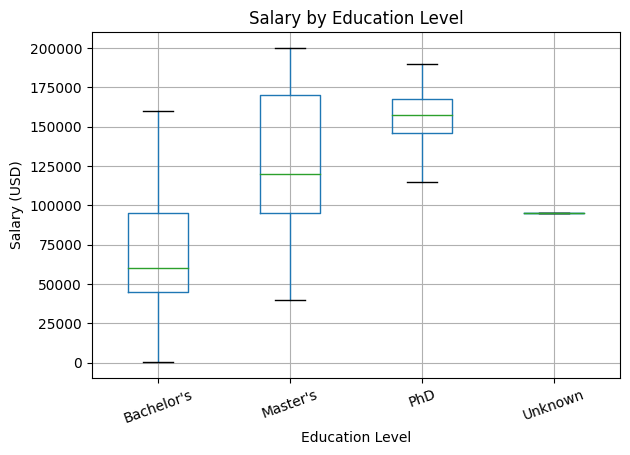

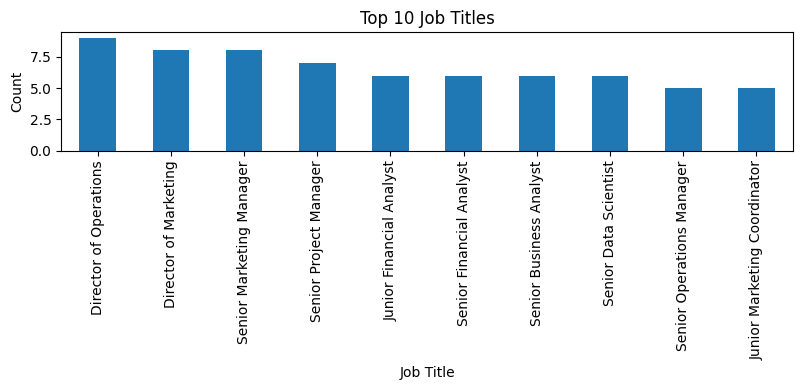

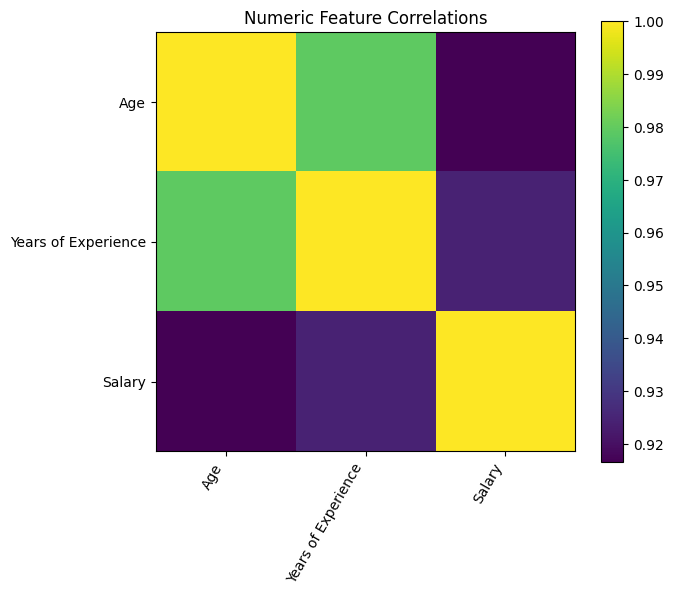

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt

FIG = Path("../reports/figures"); FIG.mkdir(parents=True, exist_ok=True)

# Salary histogram
plt.figure(figsize=(6,4))
df[salary_col].hist(bins=30)
plt.title("Salary Distribution (after cleaning)")
plt.xlabel("Salary (USD)"); plt.ylabel("Count")
plt.tight_layout(); plt.savefig(FIG/"salary_hist.png"); plt.show()

# Salary by education (boxplot)
plt.figure(figsize=(8,4))
df.boxplot(column=salary_col, by="education_level", showfliers=False, rot=20)
plt.title("Salary by Education Level"); plt.suptitle("")
plt.ylabel("Salary (USD)")
plt.tight_layout(); plt.savefig(FIG/"salary_by_education_box.png"); plt.show()

# Top 10 job titles bar chart
plt.figure(figsize=(8,4))
df["job_title"].value_counts().head(10).plot(kind="bar")
plt.ylabel("Count"); plt.title("Top 10 Job Titles")
plt.tight_layout(); plt.savefig(FIG/"top_job_titles.png"); plt.show()

# Correlation heatmap for numeric features (optional)
import numpy as np
num_cols = df.select_dtypes(include=[np.number]).columns
corr = df[num_cols].corr()
plt.figure(figsize=(7,6))
plt.imshow(corr, interpolation="nearest")
plt.xticks(range(len(num_cols)), num_cols, rotation=60, ha="right")
plt.yticks(range(len(num_cols)), num_cols)
plt.title("Numeric Feature Correlations")
plt.colorbar()
plt.tight_layout(); plt.savefig(FIG/"corr_heatmap.png"); plt.show()


In [ ]:
OUT = Path("../data/process/clean_salary_data.csv")
OUT.parent.mkdir(parents=True, exist_ok=True)
df.to_csv(OUT, index=False)
print("Clean dataset saved at:", OUT)


Clean dataset saved at: ../data/process/clean_salary_data.csv


In [ ]:
summary = {
    "rows": len(df),
    "cols": df.shape[1],
    "salary_min": float(df[salary_col].min()),
    "salary_median": float(df[salary_col].median()),
    "salary_mean": float(df[salary_col].mean()),
    "salary_max": float(df[salary_col].max()),
}
summary


{'rows': 325,
 'cols': 6,
 'salary_min': 350.0,
 'salary_median': 95000.0,
 'salary_mean': 99970.30769230769,
 'salary_max': 250000.0}